In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dolfin import *
import numpy as np

In [3]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import sympy as sp
import ulfy
from dolfin import (
    CompiledSubDomain,
    Constant,
    Function,
    FunctionSpace,
    MeshFunction,
    Point,
    RectangleMesh,
    UnitSquareMesh,
    div,
    grad,
    inner,
)


from multirat.parameters import to_constant
from multirat.multicompartment import (pressure_functionspace, process_boundaries_multicompartment, solve_timestep)
from multirat.boundary import DirichletBoundary, RobinBoundary
from multirat.meshprocessing import Domain
from multirat.utils import assign_mixed_function


def mms_domain(N, subboundaries):
    mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)
    boundary_tags = MeshFunction("size_t", mesh, dim=1, value=0)
    for tag, subd in subboundaries.items():
        subd.mark(boundary_tags, tag)
    return Domain(mesh, None, boundary_tags)


def mms_quadratic(a: float, p0: float):
    x, y = sp.symbols("x y")
    p_sym = a * (x ** 2 + y ** 2) + p0
    return p_sym


def mms_bump(a: float, p0: float):
    x, y = sp.symbols("x y")
    p_sym = a * sp.cos(sp.pi * x / 2.0) * sp.cos(sp.pi * y / 2.0) + p0
    return p_sym


def expr(exp, degree, **kwargs):
    v = mms_placeholder()
    return ulfy.Expression(v, subs={v: exp}, degree=degree, **kwargs)


def mms_sources(p, K, gamma, degree):
    p_ = {j: mms_placeholder() for j in p}
    transfer = {j: sum([gamma[(i, j)] * (p_[i] - p_[j]) for i in p if i != j]) for j in p}
    f = {j: -K[j] * div(grad(p_[j])) - transfer[j] for j in p}
    return {i: ulfy.Expression(f[i], subs={p_[j]: p[j] for j in p}, degree=degree) for i in p}


def mms_parameters():
    K = defaultdict(lambda: 1.0)
    gamma = defaultdict(lambda: 1.0)
    L_bdry = defaultdict(lambda: 1.0)
    parameters = {
        "hydraulic_conductivity": K,
        "convective_fluid_transfer": gamma,
        "hydraulic_conductivity_bdry": L_bdry,
    }
    parameters = defaultdict(
        lambda: defaultdict(lambda: 1.0),
        **parameters
    )
    return parameters


def mms_placeholder():
    mesh_ = UnitSquareMesh(1, 1)
    V_ = FunctionSpace(mesh_, "CG", 1)
    return Function(V_)


def mms_robin_boundary(pj, alpha, normals, degree):
    p_ = mms_placeholder()
    gR = {tag: p_ + 1.0 / alpha * inner(grad(p_), n) for tag, n in normals.items()}
    gR = {tag: ulfy.Expression(gR[tag], subs={p_: pj}, degree=degree) for tag in gR}
    return [RobinBoundary(alpha, gR[tag], tag) for tag in gR]


def mms_dirichlet_boundary(pj, degree, **kwargs):
    return [DirichletBoundary(expr(pj, degree, **kwargs), "everywhere")]


def mms_setup(func: str, degree=4):
    normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}
    subdomains = {
        1: CompiledSubDomain("near(x[0], -1)"),
        2: CompiledSubDomain("near(x[0], 1)"),
        3: CompiledSubDomain("near(x[1], -1)"),
        4: CompiledSubDomain("near(x[1], 1)"),
    }
    compartments = ["e", "pa", "pc", "pv"]
    a = {"e": -0.25, "pa": -1.0, "pc": 0.0, "pv": -1.0}
    p0 = {"e": 0.6, "pa": 1.0, "pc": 0.55, "pv": 0.0}
    if func == "quadratic":
        p = {j: mms_quadratic(a[j], p0[j]) for j in compartments}
    elif func == "bump":
        p = {j: mms_bump(a[j], p0[j]) for j in compartments}
    else:
        ValueError("func should be 'quadratic' or 'bump', got '{}'".format(func))

    parameters = mms_parameters()
    K = parameters["hydraulic_conductivity"]
    gamma = parameters["convective_fluid_transfer"]
    L_bdry = parameters["hydraulic_conductivity_bdry"]
    p_expr = {i: expr(p[i], degree=degree) for i in p}
    f = mms_sources(p, K, gamma, degree=degree)
    boundaries = {
        "e": mms_robin_boundary(p["e"], -L_bdry["pa"] / K["pa"], normals, degree=degree),
        "pa": mms_robin_boundary(p["pa"], -L_bdry["pa"] / K["pa"], normals, degree=degree),
        "pc": [],  # Homogeneous Neumann,
        "pv": mms_dirichlet_boundary(p["pv"], degree=degree),
    }
    return p_expr, f, boundaries, parameters, subdomains, compartments

In [4]:
def mms_solute_quadratic(a, T):
    c0 = a / 2.0
    t, x, y = sp.symbols("t x y")
    c_sym = a * (1.0 - t/T) * (x ** 2 + y ** 2) + c0
    return c_sym

def multicomp_errornorm(u, uh, compartments, norm="H1"):
    Vhigh = FunctionSpace(uh.function_space().mesh(), "CG", 5)
    return sum([errornorm(interpolate(u[j], Vhigh), uh.sub(idx), norm) for idx, j in enumerate(compartments)])


def trapezoid_internal(f, h):
    return h * (0.5 * (f[0] + f[-1]) + f[1:-1].sum())


def print_progress(t, T):
    progress = int(20 * t / T)
    print(f"[{'=' * progress}{' ' * (20 - progress)}]", end="\r")

In [5]:
def mms_sources(p, K, gamma, degree):
    p_ = {j: mms_placeholder() for j in p}
    transfer = {j: sum([gamma[(i, j)] * (p_[i] - p_[j]) for i in p if i != j]) for j in p}
    f = {j: -K[j] * div(grad(p_[j])) - transfer[j] for j in p}
    return {i: ulfy.Expression(f[i], subs={p_[j]: p[j] for j in p}, degree=degree) for i in p}

In [6]:
def solute_transfer(c_, p_, L, G, phi):
    s = {}
    for j in c_:
        s[j] = 0.0
        for i in c_:
            if i == j:
                continue
            s[j] += L[(i, j)] * (c_[i] - c_[j]) + 0.5 * G[(i, j)] * (c_[i] + c_[j]) * (p_[i] - p_[j])
    return s

def solute_sources(c, p, time, K, phi, D, L, G, degree):
    c_ = {j: mms_placeholder() for j in c}
    dcdt_ = {j: mms_placeholder() for j in c}
    p_ = {j: mms_placeholder() for j in c}
    s = solute_transfer(c_, p_, L, G, phi)
    f = {
        j: dcdt_[j] - (K[j] / phi[j] * div(c_[j] * grad(p_[j]))) - (D[j] * div(grad(c_[j]))) - s[j] 
        for j in c
    }
    subs = {
        **{dcdt_[j]: sp.diff(c[j], "t") for j in c},
        **{c_[j]: c[j] for j in c},
        **{p_[j]: p[j] for j in c}
    }
    return {i: ulfy.Expression(f[i], subs=subs, degree=degree, t=time) for i in c}

In [7]:
degree = 4
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}
subdomains = {
    1: CompiledSubDomain("near(x[0], -1)"),
    2: CompiledSubDomain("near(x[0], 1)"),
    3: CompiledSubDomain("near(x[1], -1)"),
    4: CompiledSubDomain("near(x[1], 1)"),
}

params = mms_parameters()
phi, D, K, G, L = to_constant(
    params,
    "porosity",
    "effective_diffusion",
    "hydraulic_conductivity",
    "convective_solute_transfer",
    "diffusive_solute_transfer",
)


# Time
dt = 0.1
endtime = 1.0
compartments = ["pa", "pc"]#, "pv"]
a = {"e": 0.25, "pa": -1.0, "pc": -0.5, "pv": -0.2}
ap = defaultdict(lambda: -1.0)
p0 = defaultdict(lambda: 2.0)

p = {j: mms_quadratic(ap[j], p0[j]) for j in compartments}
time = Constant(0.0)
c = {j: mms_solute_quadratic(a[j], T=endtime) for j in compartments} # Sympy forms
f = solute_sources(c, p, time, K, phi, D, L, G, degree)
c_expr = {j: expr(c[j], degree=degree, t=time) for j in compartments}
boundaries = {j: mms_dirichlet_boundary(c[j], degree=degree, t=time) for j in compartments}

In [27]:
degree = 4
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}
subdomains = {
    1: CompiledSubDomain("near(x[0], -1)"),
    2: CompiledSubDomain("near(x[0], 1)"),
    3: CompiledSubDomain("near(x[1], -1)"),
    4: CompiledSubDomain("near(x[1], 1)"),
}

params = mms_parameters()
phi, D, K, G, L = to_constant(
    params,
    "porosity",
    "effective_diffusion",
    "hydraulic_conductivity",
    "convective_solute_transfer",
    "diffusive_solute_transfer",
)


# Time
dt = 0.1
endtime = 1.0
compartments = ["pa", "pc", "pv"]


ap = {"pa": -1.0, "pc": -0.5, "pv": 0.8}
p0 = {"pa": 1.0, "pc": 0.5, "pv": 0.0}
p_sym = {j: mms_quadratic(ap[j], p0[j]) for j in compartments}


ac = {"pa": -1.0, "pc": -0.5, "pv": -0.2}
c = {j: mms_solute_quadratic(ac[j], T=endtime) for j in compartments} # Sympy forms


time = Constant(0.0)
f = solute_sources(c, p_sym, time, K, phi, D, L, G, degree)
c_expr = {j: expr(c[j], degree=degree, t=time) for j in compartments}
p_expr = {j: expr(p_sym[j], degree=degree) for j in compartments}
boundaries = {j: mms_dirichlet_boundary(c[j], degree=degree, t=time) for j in compartments}


hvec = []
E = []
for N in [2, 3, 4, 5]:#, 6, 7, 8]:
    print(" N =", N)
    print()
    time.assign(0.0)
    domain = mms_domain(2**N, subdomains)
    V = pressure_functionspace(domain.mesh, 1, compartments)
    source = f

    c = TrialFunctions(V)
    w = TestFunction(V)
    p = assign_mixed_function(p_expr, V, compartments)
    C0 = assign_mixed_function(c_expr, V, compartments)

    # Define variational form.
    F = 0.0
    for idj, j in enumerate(compartments):
        F += (c[idj] - C0[idj]) * w[idj] * dx
        F += dt * (inner(D[j] * grad(c[idj]) + K[j] / phi[j] * c[idj] * grad(p[idj]), grad(w[idj]))) * dx
        sj = 0.0
        for idi, i in enumerate(compartments):
            if idi == idj:
                continue
            sj += (
                L[(i, j)] * (c[idi] - c[idj])
                + G[(i, j)] * (p[idi] - p[idj]) * (0.5 * (c[idi] + c[idj]))
            ) / phi[j]
        F -= dt * sj * w[idj] * dx
        if source is not None:
            F -= dt * source[j] * w[idj] * dx

    F_bdry, bcs = process_boundaries_multicompartment(c, w, boundaries, V, compartments, domain)
    F -= dt * F_bdry
    a = lhs(F)
    l = rhs(F)
    A = assemble(a)


    Ch = Function(V, name="concentration")
    errs = np.nan * np.zeros(100)
    idx = 0
    errs[idx] = multicomp_errornorm(c_expr, C0, compartments, "H1")
    while float(time) <= endtime:
        time.assign(time + dt)
        print_progress(float(time), endtime)
        Ch = solve_timestep(A, l, Ch, bcs)
        C0.assign(Ch)

        C0_ = assign_mixed_function(c_expr, V, compartments)
        err = abs(Ch.vector()[:] - C0_.vector()[:]).max()
        idx+=1
        errs[idx] = multicomp_errornorm(c_expr, C0, compartments, "H1")

    errs = errs[~np.isnan(errs)]    
    temporal_error = np.sqrt(trapezoid_internal(errs**2, dt))
    E.append(temporal_error)
    hvec.append(domain.mesh.hmax())

 N = 2

 N = 3================]

 N = 4================]

 N = 5================]



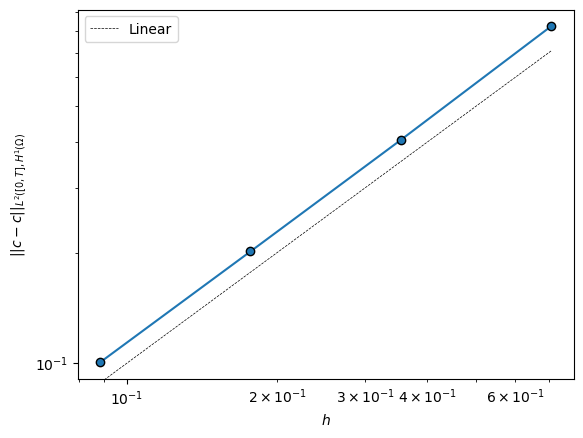

In [29]:
savepath = (Path() / "../results/mms").resolve()
savepath.mkdir(exist_ok=True)

plt.figure()
plt.loglog(hvec, E, "-o", markeredgecolor='k')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.autoscale(False)
plt.loglog(hvec, hvec, 'k--', lw=0.5, label="Linear")
plt.ylim(ylim)

plt.xlabel("$h$")
plt.ylabel(r"$||c - c||_{L^2([0, T], H^1(\Omega)}$")
plt.legend()
plt.savefig(savepath / "convergence-concentration.png")
plt.show()

In [24]:
print("h_i / h_i+1 \t E_i / E_i+1 \t\t log(E_i/E_i+1) / log(h_i / h_i+1)")
print("-" * 80)

for i in range(len(E) - 1):
    print(hvec[i] / hvec[i+1], "\t\t", E[i] / E[i+1], "\t", np.log(E[i] / E[i+1]) / np.log(hvec[i] / hvec[i+1]))

h_i / h_i+1 	 E_i / E_i+1 		 log(E_i/E_i+1) / log(h_i / h_i+1)
--------------------------------------------------------------------------------
2.0 		 2.033389129427509 	 1.02388632997598
2.0 		 2.0084588197802464 	 1.0060888815437605
2.0 		 2.0021223209849106 	 1.0015301192725001
2.0 		 2.000531071158261 	 1.0003830360105972
2.0 		 2.000132798763812 	 1.0000957908788013
2.0 		 2.0000332016537703 	 1.0000239497318297
